In [1]:
try:
    # mount google drive
    from google.colab import drive  # nopep8
    drive_path = "/content/drive"
    drive.mount(drive_path)
    drive_folder = drive_path + "/MyDrive/dtm/"
    using_colab = True
except ModuleNotFoundError:
    # Assume we are not on google colab,
    drive_folder = "data/"
    using_colab = False
    pass

Mounted at /content/drive


In [2]:
!pip -q install --upgrade pip
!pip -q install plyfile deepdiff GitPython imgaug
!pip -q install --upgrade imgaug
import matplotlib.pyplot as plt
import sys
import importlib
import numpy as np
import math
import os, re
from tensorflow import keras
import json
import git
import importlib
import cv2
import imgaug.augmenters as iaa
import datetime

     |████████████████████████████████| 1.6MB 3.0MB/s 
     |████████████████████████████████| 66 kB 1.3 MB/s 
     |████████████████████████████████| 166 kB 11.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 948 kB 3.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [3]:
if using_colab:
    !git -C /content/deep_ga/ pull || git clone https://github.com/InigoMoreno/deep_ga
    sys.path.append('/content/deep_ga')
    import deep_ga  # nopep8
    deep_ga=importlib.reload(deep_ga)
else:
    MODULE_PATH = "deep_ga/deep_ga/__init__.py"
    MODULE_NAME = "deep_ga"
    git.cmd.Git(MODULE_NAME).pull()
    spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
    deep_ga = importlib.util.module_from_spec(spec)
    sys.modules[spec.name] = deep_ga
    spec.loader.exec_module(deep_ga)


fatal: cannot change to '/content/deep_ga/': No such file or directory
Cloning into 'deep_ga'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (553/553), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 553 (delta 373), reused 504 (delta 324), pack-reused 0
Receiving objects: 100% (553/553), 457.14 KiB | 3.75 MiB/s, done.
Resolving deltas: 100% (373/373), done.


In [4]:
p={
  "resolution" : 1,                      # resolution of map [meters per pixel]
  "mapLength"  : 80,                    # size of one side of the map [meters]
  "minSlopeThreshold"  : 0.5,            # minimum slope to be counted [proportion]
  "maxNanPercentage"   : 5/100,           # maximum percentage of NaNs in a patch [%]
  "minSlopePercentage" : 10/100,          # minimum percentage of slope in a patch [%]
  "maxSlopePercentage" : 40/100,          # maximum percentage of slope in a patch [%]
  "stdPatchShift"          : 15,          # standard deviation of shift between to patches [m]
  "local_resolution" : .5,
  "local_mapLength"  : 40,
  "local_maxNanPercentage": 65/100,
  "local_global_minCcorr": 15/100,
   "raycastHeight": 2,
   "booleanDist": False
}
p["mapLengthPixels"]=math.ceil(p["mapLength"]/p["resolution"])
p["local_mapLengthPixels"]=math.ceil(p["local_mapLength"]/p["local_resolution"])

deep_ga.set_scale(p["stdPatchShift"])
p["augment_a"] = iaa.Sequential([
    iaa.PerspectiveTransform(scale=0.01),
    iaa.BlendAlphaSimplexNoise(iaa.Add(0.4), upscale_method="cubic", size_px_max=4),
])

pt={
  "resolution" : .5,                     # resolution of map [meters per pixel]
  "mapLength"  : 40,                     # size of one side of the map [meters]
  "minSlopeThreshold"  : 0.5,            # minimum slope to be counted [proportion]
  "maxNanPercentage"   : 5/100,          # maximum percentage of NaNs in a patch [%]
  "minSlopePercentage" : 0/100,          # minimum percentage of slope in a patch [%]
  "maxSlopePercentage" : 100/100,        # maximum percentage of slope in a patch [%]
  "stdPatchShift"          : 10,         # standard deviation of shift between to patches [m]
  "local_resolution" : .5,
  "local_mapLength"  : 40,
  "local_maxNanPercentage": 65/100,
  "local_global_minCcorr": 15/100,
   "booleanDist": False
   
}
pt["mapLengthPixels"]=math.ceil(pt["mapLength"]/pt["resolution"])
pt["local_mapLengthPixels"]=math.ceil(pt["local_mapLength"]/pt["local_resolution"])

In [5]:
!pip -q install gdal wget
import gdal, wget, os

!pip -q install gdal wget
import gdal, wget, os

filename="oxia_planum.IMG"

filename=os.path.join(drive_folder, "oxia_planum.IMG")

#get file if it does not exist
#from https://www.uahirise.org/dtm/dtm.php?ID=ESP_037070_1985
url = "https://www.uahirise.org/PDS/DTM/ESP/ORB_037000_037099/ESP_037070_1985_ESP_037136_1985/DTEEC_037070_1985_037136_1985_L01.IMG"
if not os.path.isfile(filename):
  wget.download(url,out = filename)

#transform to numpy array
gdata=gdal.Open(filename)
height=gdata.GetRasterBand(1).ReadAsArray()
height[height<-1e38]=np.nan
height = cv2.resize(height, None, interpolation = cv2.INTER_AREA,
                    fx=gdata.GetGeoTransform()[1] / p["resolution"],
                    fy=-gdata.GetGeoTransform()[5] / p["resolution"])


filename=os.path.join(drive_folder, "jezero.IMG")

#get file if it does not exist
#from https://www.uahirise.org/dtm/dtm.php?ID=ESP_023247_1985
url = "https://www.uahirise.org/PDS/DTM/ESP/ORB_023200_023299/ESP_023247_1985_ESP_022957_1985/DTEEC_023247_1985_022957_1985_U01.IMG"
if not os.path.isfile(filename):
  wget.download(url,out = filename)

#transform to numpy array
gdata=gdal.Open(filename)
height2=gdata.GetRasterBand(1).ReadAsArray()
height2[height2<-1e38]=np.nan
height2 = cv2.resize(height2, None, interpolation = cv2.INTER_AREA,
                    fx=gdata.GetGeoTransform()[1] / p["resolution"],
                    fy=-gdata.GetGeoTransform()[5] / p["resolution"])


In [6]:
#get local_dems
with np.load(os.path.join(drive_folder,"processed","filtered.npz")) as data:
  dems=data["dems"]
  gps= data["gps"]
#get global_dem
ply_file=os.path.join(drive_folder,"minas_densified_point_cloud.ply")
global_dem , global_img, displacement = deep_ga.ply_to_image(ply_file,pt["resolution"])

In [7]:
day = np.vectorize(lambda a: datetime.datetime.utcfromtimestamp(a).day)(gps[:,0]/1e6)
validation = day==8

tdems=dems[~validation,:,:]
vdems=dems[validation,:,:]
tgps=gps[~validation,:]
vgps=gps[validation,:]

Nv=vdems.shape[0]
Nt=tdems.shape[0]
print(f"Validation split: {Nv/(Nt+Nv)*100:.1f}%")

del dems, gps

Validation split: 12.1%


In [10]:
keras.backend.clear_session()
dataset="ten"
# dataset="ten"
if dataset=="ten":

  experiment_path=os.path.join(drive_folder)
  i="False__3"
  filepath = os.path.join(experiment_path,f"{i}.h5")
  # i="DOOMSE"
  # jsonpath = os.path.join(drive_folder,"talos_tenerife_inputs",f"{i}.json")
  # with open(jsonpath,'rb') as f:
  #   parsed=json.load(f)
  #   print(json.dumps(parsed, indent=4, sort_keys=True))
else:
  # i="1_0__0__100"
  experiment_path=os.path.join(drive_folder,"talos_oxia_loss")
  i="DOOMSE"
  filepath = os.path.join(experiment_path,f"{i}.h5")
  # jsonpath = os.path.join(drive_folder,"talos_tenerife_inputs",f"{i}.json")
  # with open(jsonpath,'rb') as f:
  #   parsed=json.load(f)
  #   print(json.dumps(parsed, indent=4, sort_keys=True))

model=keras.models.load_model(filepath, custom_objects=deep_ga.custom_objects,compile=False)

try:
  model2=model.get_layer("single_branch")
except ValueError:
  model2=model.get_layer("branch_a")
  model2b=model.get_layer("branch_b")
# keras.utils.plot_model(model2, show_shapes=True, expand_nested=False)

In [11]:
import matplotlib.pyplot as plt



# get validation data generator
vp=p.copy()
vp["augment_a"]=None
vpt=pt.copy()
vpt["augment_a"]=None

if dataset=="ten":
  print("Tenerife")
  tgenerator=deep_ga.LocalGlobalPatchDataGenerator(5000,32,tdems,tgps,global_dem,displacement,pt)
  vgenerator=deep_ga.LocalGlobalPatchDataGenerator(5000,32,vdems,vgps,global_dem,displacement,vpt)
else:
  print("Oxia")
  tgenerator=deep_ga.PatchDataGenerator(5000,height,batch_size=32,params=p)
  vgenerator=deep_ga.PatchDataGenerator(5000,height2,batch_size=32,params=vp)


%time x,y=vgenerator.get_batch(2000)
%time yp=model.predict(x)[:,0]

Tenerife
CPU times: user 886 ms, sys: 114 ms, total: 1e+03 ms
Wall time: 1 s
CPU times: user 33.8 s, sys: 2.73 s, total: 36.6 s
Wall time: 20.3 s


38.528454


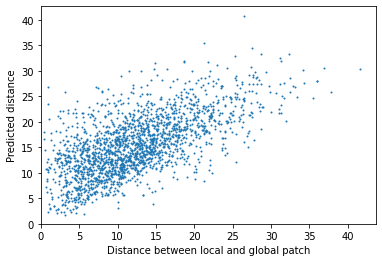

In [12]:
from tensorflow import keras
print(keras.losses.MSE(y,yp).numpy())
# img=np.histogram2d(y,yp,bins=100, range=((0,20),(0,20)))
plt.scatter(y, yp, 1)
# plt.scatter(y, np.full_like(yp,np.mean(yp)), 1)
# plt.plot(y,y)
plt.xlim(0,plt.xlim()[1])
plt.ylim(0,plt.ylim()[1])
# plt.grid(linestyle="--")
plt.xlabel("Distance between local and global patch")
plt.ylabel("Predicted distance")
plt.savefig(f"{i}.pdf")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


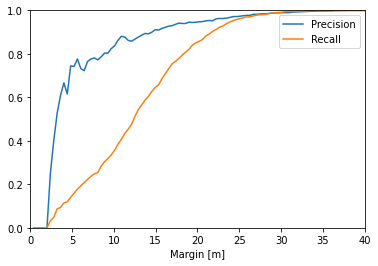

In [13]:
import keras.backend as K
import keras
ms=np.linspace(0,40,100)
data1=[]
data2=[]
for m in ms:
  ytm=np.array(y)<m
  ypm=np.array(yp)<m


  tp=np.sum(ytm & ypm)
  fp=np.sum(np.logical_not(ytm) & ypm)
  fn=np.sum(ytm & np.logical_not(ypm))

  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  data1.append(precision)
  data2.append(recall)
plt.plot(ms,data1)
plt.plot(ms,data2)
plt.legend(["Precision","Recall"])
plt.ylim([0,1])
plt.xlim([0,40])
plt.xlabel("Margin [m]")
plt.savefig("precision_recall_hirise.pdf")
plt.show()

(2000, 50)


(0.0, 1.0)

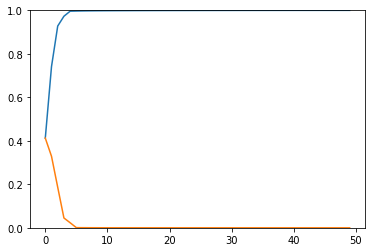

In [14]:
from sklearn.decomposition import PCA

pca=PCA()
# pca.fit()
y2=model2.predict(x[0])
print(y2.shape)
pca.fit(y2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_)
# plt.xlim(0,20)
plt.ylim(0,1)

In [15]:
np.sum(np.cumsum(pca.explained_variance_ratio_)<0.99)

4

In [16]:

def get_slope(patch, resolution=1):
    slopeX = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)/resolution
    slopeY = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)/resolution
    slope = cv2.magnitude(slopeX, slopeY)
    return slope

def get_corr(a,b):
  t = np.nan_to_num(get_slope(a.astype("float32"),p["resolution"]))
  i = np.nan_to_num(get_slope(b.astype("float32"),p["resolution"]))
  # slope_b = np.zeros((100,100),"float32")

  # res = cv2.matchTemplate(slope_a,slope_b,cv2.TM_CCORR_NORMED)
  res= np.sum(t*i)/np.sqrt(np.sum(np.square(t))*np.sum(np.square(i)))
  return res

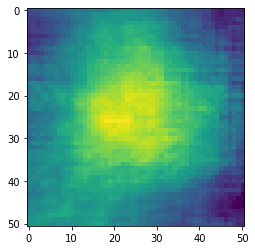

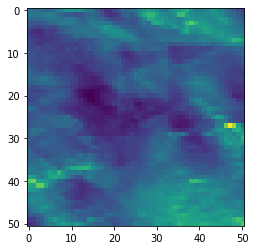

In [17]:
from tqdm.notebook import tqdm
W=50
xs=list(np.linspace(-W,W,51))
dps=np.empty((len(xs),len(xs)))
dcs=np.empty((len(xs),len(xs)))
# print(xs)
for i,x in enumerate(tqdm(xs)):
  for j,y in enumerate(tqdm(xs,leave=False)):
    if dataset=="ten":
      (l,g,d)=deep_ga.get_batch_local_global(1,vdems,vgps,global_dem,displacement,vpt,4,(x,y))
    else:
      (l,g,d)=deep_ga.get_batch(1,height2,vp,4,(x,y))
    if g is None:
      dp=None
      dc=None
    else:
      dp=model.predict((l,g))
      dc=get_corr(l,g)
    dps[i,j]=dp
    dcs[i,j]=dc
plt.imshow(-dps)
plt.show()
plt.imshow(dcs)
plt.show()

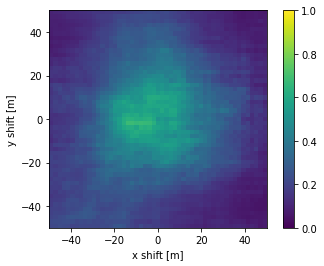

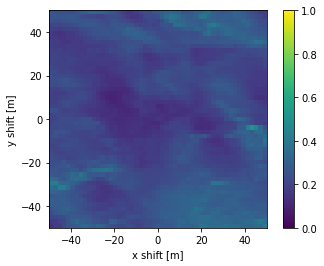

In [45]:
dss=1-np.tanh(dps*0.8/15)
plt.imshow(dss, extent=(-W,W,-W,W))
plt.xlabel("x shift [m]")
plt.ylabel("y shift [m]")
plt.clim((0,1))
plt.colorbar()
plt.savefig(f"pred_{dataset}.pdf",bbox_inches="tight",pad_inches=0)
plt.show()
plt.imshow(dcs, extent=(-W,W,-W,W))
plt.xlabel("x shift [m]")
plt.ylabel("y shift [m]")
plt.clim((0,1))
plt.colorbar()
plt.savefig(f"corr_{dataset}.pdf",bbox_inches="tight",pad_inches=0)
plt.show()

In [48]:
print(np.max(dss))
i,j=np.where(dss==np.max(dss))
print(np.sqrt(xs[i[0]]**2+xs[j[0]]**2))

0.6818976900319926
14.142135623730951


In [57]:
from tqdm.notebook import tqdm
dsss=[]
dcss=[]
for seed in tqdm(range(20)):
  W=50
  xs=list(np.linspace(-W,W,11))
  dps=np.empty((len(xs),len(xs)))
  dcs=np.empty((len(xs),len(xs)))
  # print(xs)
  for i,x in enumerate(tqdm(xs,leave=False)):
    for j,y in enumerate(tqdm(xs,leave=False)):
      if dataset=="ten":
        (l,g,d)=deep_ga.get_batch_local_global(1,vdems,vgps,global_dem,displacement,vpt,seed,(x,y))
      else:
        (l,g,d)=deep_ga.get_batch(1,height2,vp,seed,(x,y))
      if g is None:
        dp=None
        dc=None
      else:
        dp=model.predict((l,g))
        dc=get_corr(l,g)
      dps[i,j]=dp
      dcs[i,j]=dc
  dss=1-np.tanh(dps*0.8/15)
  i,j=np.where(dss==np.max(dss))
  dsss.append(np.sqrt(xs[i[0]]**2+xs[j[0]]**2))
  i,j=np.where(dcs==np.max(dcs))
  dcss.append(np.sqrt(xs[i[0]]**2+xs[j[0]]**2))


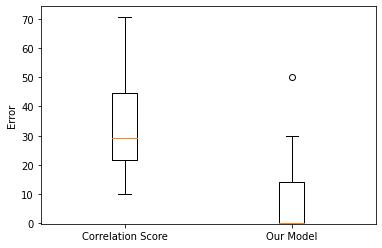

In [68]:
plt.boxplot([dcss,dsss],labels=["Correlation Score","Our Model"]);
plt.ylabel("Error")
plt.ylim((-0.15,plt.ylim()[1]))
plt.savefig("comparation.pdf")

In [19]:
import time
N=10000
(l,g,d)=deep_ga.get_batch_local_global(N,vdems,vgps,global_dem,displacement,vpt,4)

now = time.time()
[get_corr(l[i,:,:],g[i,:,:]) for i in range(N)]
later = time.time()
print(1000*(later - now)/N)

KeyboardInterrupt: ignored